In [ ]:
# #gpu
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

In [ ]:
# #cpu
# !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [ ]:
!pip install wandb torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=cdeaa3c019323074ddb1d3a427937f81dbe6faa22ed4dcf90e2a45abfd28d30c
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
from torch_geometric.utils import (
    add_self_loops,
    negative_sampling,
    remove_self_loops ,
)
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings("ignore")
import time


import numpy as np
import scipy.sparse as sp
from torch import nn
import pandas as pd
# import networkx as nx
from typing import List , Dict,Tuple
from torch_geometric.nn import SAGEConv, to_hetero
import torch

import matplotlib.pyplot as plt
import torch_geometric.nn as  gnn
from torch_geometric.data  import Data
from torch_geometric.data import HeteroData

from torch.nn import functional as F
import torch
from torch.optim.adamw import AdamW
import time
from argparse import ArgumentParser
import argparse
import wandb
import numpy as np
import random
import os
import datetime
from tqdm import tqdm
generator = torch.manual_seed(232)
np.random.seed(232)
torch.cuda.manual_seed(232)
torch.cuda.manual_seed_all(232)
random.seed(232)


In [ ]:

# """
# https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
# """
from torch_geometric.data  import InMemoryDataset
class WeekGraphs(InMemoryDataset):
    def __init__(self, root, data_list, transform=None):
        if len(data_list) != 0:
          self.data_list = data_list
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])
# dataset = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_dataset", [])

In [ ]:
train = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_trainset", [])
test = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_testset", [])

In [ ]:
len(train), len(test)

(1025, 257)

In [ ]:
from torch_geometric.loader import DataLoader


train_loader = DataLoader(train, batch_size=8)
test_loader = DataLoader(test, batch_size=8, shuffle=False)

In [ ]:


class LSTM(nn.Module):
    def __init__(self, input_size=1, num_layers=2,hidden_size=64, output_size=64, num_steps =10 ):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.batch_norm1 = nn.BatchNorm1d(num_steps)
        
    def forward(self, x):
        # h0 = torch.zeros(2, x.size(0), 100).to(device) # num_layers * num_directions, batch_size, hidden_size
        # c0 = torch.zeros(2, x.size(0), 100).to(device)
        x = self.batch_norm1(x)
        out, _ = self.lstm1(x)
        # out, _ = self.lstm2(out)
        out = F.gelu(self.fc1(out[:, -1, :]))
        return out



In [ ]:


class GConv(nn.Module):

    def __init__(self, emb_dim:int=64, num_layers:int=2, encode:bool=True, concat_out:bool=False, device='cpu', dropout=0.2):
     
        super(GConv,self).__init__()
        self.num_layers = num_layers
        self.gconv_layers = []
        self.norm_layers = []
        self.encode = encode
        for _ in range(num_layers):
            self.gconv_layers.append(gnn.SAGEConv(emb_dim, emb_dim, dropout=dropout, project=True).to(device)) # project=True ()
            if self.encode:
                self.norm_layers.append(nn.LayerNorm(emb_dim).to(device))
        self.gconv_layers = nn.ModuleList(self.gconv_layers)
        self.norm_layers = nn.ModuleList(self.norm_layers)

        self.concat_out = concat_out
    
    def forward(self, x, edge_index):
        
        outs = []
        if self.encode:
            outs.append(self.norm_layers[0](self.gconv_layers[0](x, edge_index)))
        else:
            outs.append(self.gconv_layers[0](x, edge_index))
        for i in range(1,self.num_layers):
            if self.encode:
                outs.append(self.norm_layers[i](self.gconv_layers[i](outs[-1], edge_index)))
            else:
                outs.append(self.gconv_layers[i](outs[-1], edge_index))
        if self.concat_out:
            return torch.cat(outs, dim = -1)
        
        return outs[-1]
      


class NeuroStock(nn.Module):

  def __init__(self,
               num_timeseries_features=1,
               n_companies=325, 
               company_emb_size=32, 
               node_emb_size=64,
               article_emb_size=768,
               n_industries=14,
               n_gnn_layers=3,
               graph_metadata:Tuple=None):
    super(NeuroStock, self).__init__()
    """
    company node representation will be a concatenation of its embedding and the output of the timeseries model (in this case it's an LSTM)
    """
    self.num_timeseries_features = num_timeseries_features
    self.n_companies = n_companies 
    self.company_emb_size = company_emb_size 
    self.node_emb_size = node_emb_size
    self.article_emb_size = article_emb_size
    self.n_industries = n_industries
    self.n_gnn_layers = n_gnn_layers
    self.lstm = LSTM(input_size=num_timeseries_features,  hidden_size=company_emb_size, output_size=company_emb_size).to(torch.float)

    if graph_metadata is None:
      raise("You need to pass HeteroData.metadata()")
    self.company_embedding = nn.Embedding(n_companies, company_emb_size).to(torch.float)
    self.industry_embedding = nn.Embedding(n_industries, node_emb_size).to(torch.float)
    self.project_article = nn.Linear(article_emb_size, node_emb_size).to(torch.float)

    # to_hetero transforms normal gnn aggregation layer to a heterogeneous aggregation layer
    # https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero  
    self.g_conv = gnn.to_hetero(GConv(emb_dim=node_emb_size, num_layers=n_gnn_layers), graph_metadata).to(torch.float)
    self.classifier = nn.Linear(node_emb_size, 1).to(torch.float)

  def forward(self, hetero_x:HeteroData):
    hetero_x["article"].x = self.project_article(hetero_x["article"].x)
    companies = self.company_embedding(hetero_x["company"].x)
    # print(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.double).shape, hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float).dtype)
    # company_timeseries is of shape (n_companies*batch_size, n_days, n_features)  the features are "open", "high", "low", "close", "volume" 
    companies_timeseries = self.lstm(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float))
    hetero_x["company"].x = torch.cat((companies_timeseries, companies), dim=-1)  #companies are in shape (n_companies*batch_size, node_emb_size) 
    hetero_x["industry"].x = self.industry_embedding(hetero_x["industry"].x)
    graph = self.g_conv(hetero_x.x_dict, hetero_x.edge_index_dict)
    out = F.sigmoid(self.classifier(graph["company"]))
    return out
  
  def compute_loss(self, out, target):
    loss = F.binary_cross_entropy(out.reshape(-1), target.float())
    return loss


In [ ]:
import wandb 

from   tqdm import tqdm
wandb.init(
        project="test_gnn", 
        name="test_run1",
        mode="online")

n_epochs = 50
# warmup_steps=

neurostock = NeuroStock(node_emb_size=32, company_emb_size=16, graph_metadata=train[0].metadata()) 
neurostock.to('cuda')
device = next(neurostock.parameters()).device
optimizer =  torch.optim.AdamW(neurostock.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1,  total_iters=warmup_steps)
for e in tqdm(range(n_epochs)):
    train_losses= []
    neurostock.train()
    train_outs = []
    train_targets = []
    for batch  in train_loader: 
        # with torch.autocast(device_type="cuda", dtype=torch.float16):
        batch = batch.to(device)
        out = neurostock(batch) 
        train_outs.append(out.cpu().detach().reshape(-1))
        train_targets.append(batch["target"].cpu().detach().reshape(-1))
        loss = neurostock.compute_loss(out, batch["target"])
        optimizer.zero_grad()
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    neurostock.eval()
    valid_losses = []
    # continue
    valid_outs = []
    valid_targets = []
    with torch.no_grad():
        for batch  in test_loader: 
            
          batch = batch.to(device)
          out = neurostock(batch) 
          valid_outs.append(out.reshape(-1).cpu().detach())
          valid_targets.append(batch["target"].reshape(-1).cpu().detach())
          loss = neurostock.compute_loss(out, batch["target"])
          valid_losses.append(loss.item())

    valid_outs = torch.cat(valid_outs).numpy()
    valid_targets = torch.cat(valid_targets).numpy()
    valid_acc = ((valid_outs >= 0.5) == valid_targets).mean()
    train_outs = torch.cat(train_outs).numpy()
    train_targets = torch.cat(train_targets).numpy()
    train_acc = ((train_outs >= 0.5) == train_targets).mean()
    wandb.log({
          "train_loss" : np.mean(train_losses),
          "valid_loss" : np.mean(valid_losses),
          "valid_acc" : valid_acc,
          "train_acc" : train_acc
    })
wandb.finish()


100%|██████████| 50/50 [04:19<00:00,  5.20s/it]


train_acc,▁▁▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▇▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
valid_acc,▁▁▃▃▅▆▆▇▆▇▆█▇▇▆▇▆▇▇▇▇▇▇▇▇▆▆▇█▆▇▆▆▆▅▅▆▅▅▆
valid_loss,▄▃▂▂▂▂▁▂▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▃▃▃▄▆▅▇█▆▇▆▇▇███
train_acc,0.55315
train_loss,0.68023
valid_acc,0.51984
valid_loss,0.69647


In [ ]:
2600 / 8

325.0

In [ ]:
neurostock.eval()
valid_losses = []
# continue
valid_outs = []
valid_targets = []
with torch.no_grad():
    for batch  in test_loader: 
        
      batch = batch.to(device)
      out = neurostock(batch) 
      outs = torch.cat([ k.unsqueeze(0) for k in out.chunk(batch["company"].ptr.shape[0]-1)]).squeeze(-1).cpu().detach()
      targets = torch.cat([ k.unsqueeze(0) for k in batch["target"].chunk(batch["company"].ptr.shape[0]-1)]).cpu().detach()
      valid_outs.append(outs)
      valid_targets.append(targets)
      loss = neurostock.compute_loss(out, batch["target"])
      valid_losses.append(loss.item())
valid_outs = torch.cat(valid_outs).numpy()
valid_targets = torch.cat(valid_targets).numpy()


In [ ]:
valid_outs.shape, valid_targets.shape

(torch.Size([257, 325]), torch.Size([257, 325]))

(<Axes: >, 0.5192696797366058)

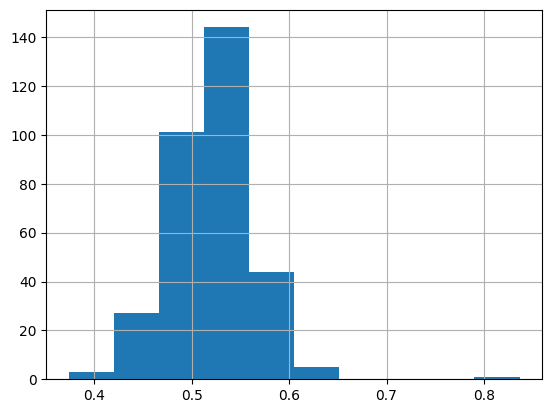

In [ ]:
import pandas as pd
acc_per_company  = ((valid_outs >= 0.4) == valid_targets).mean(0)
pd.Series(acc_per_company).hist(), acc_per_company.mean()

<Axes: >

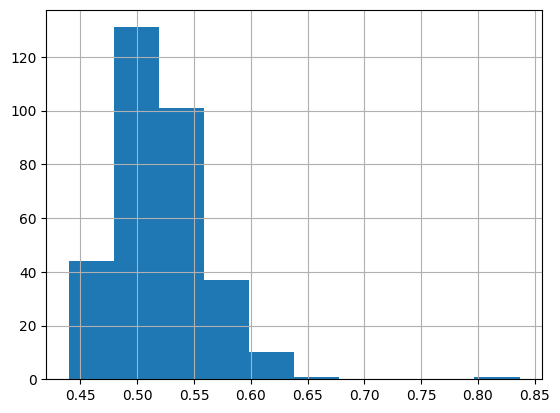

In [ ]:
import pandas as pd
acc_per_company  = ((valid_outs.numpy() >= 0.5) == valid_targets.numpy()).mean(0)
pd.Series(acc_per_company).hist()

In [ ]:
acc_per_company[acc_per_company.argsort()[-20:]]

array([0.57198444, 0.57587549, 0.57587549, 0.57976654, 0.58365759,
       0.58365759, 0.58365759, 0.58754864, 0.58754864, 0.58754864,
       0.58754864, 0.59533074, 0.59922179, 0.60311284, 0.60700389,
       0.60700389, 0.61089494, 0.61089494, 0.63035019, 0.83657588])

In [ ]:
import pandas as pd 
nasdaq_screener = pd.read_csv("/content/drive/MyDrive/Stock Market Prediction Graduation Project/nasdaq_screener.csv")
news_df = pd.read_csv("/content/drive/MyDrive/Stock Market Prediction Graduation Project/processed_news_df.csv")
news_df["mentioned_companies"] = news_df["mentioned_companies"].apply(lambda x: x[1:-1].replace("'","").replace(" ", "").split(","))
stock_df = pd.read_csv("/content/drive/MyDrive/Stock Market Prediction Graduation Project/processed_stock_df.csv")

In [ ]:
industry_to_index = {k : v for v,k in enumerate(nasdaq_screener["Sector"].unique()) }
company_to_index = {k :v for v,k in zip(range(news_df["symbol"].nunique()), news_df["symbol"].unique()) }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse 

In [ ]:
nasdaq_screener[nasdaq_screener["Symbol"].isin(best_acc_companies)]

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
392,AMAT,Applied Materials Inc. Common Stock,$119.98,-4.28,-3.444%,1.011525e+11,United States,1972.0,6156490,Technology,Semiconductors
403,AMD,Advanced Micro Devices Inc. Common Stock,$86.09,-2.22,-2.514%,1.400999e+11,United States,NaN,66525144,Technology,Semiconductors
717,ATVI,Activision Blizzard Inc. Common Stock,$75.24,-1.87,-2.425%,5.888473e+10,United States,NaN,5779432,Consumer Discretionary,Recreational Games/Products/Toys
1535,CHRW,C.H. Robinson Worldwide Inc. Common Stock,$103.62,-0.76,-0.728%,1.219706e+10,United States,1997.0,2005278,Consumer Discretionary,Oil Refining/Marketing
1656,CMCSA,Comcast Corporation Class A Common Stock,$39.97,-1.14,-2.773%,1.728066e+11,United States,NaN,20404359,Consumer Discretionary,Telecommunications Equipment
1865,CSCO,Cisco Systems Inc. Common Stock (DE),$48.63,-0.69,-1.399%,1.997771e+11,United States,1990.0,17974866,Telecommunications,Computer Communications Equipment
1888,CSX,CSX Corporation Common Stock,$32.27,-0.37,-1.134%,6.784473e+10,United States,NaN,9576970,Industrials,Railroads
2292,EBAY,eBay Inc. Common Stock,$50.66,-1.00,-1.936%,2.749111e+10,United States,1998.0,3807906,Consumer Discretionary,Catalog/Specialty Distribution
2601,EXC,Exelon Corporation Common Stock,$40.90,-0.99,-2.363%,4.064405e+10,United States,NaN,6980170,Utilities,Power Generation
2635,FAST,Fastenal Company Common Stock,$54.20,-1.09,-1.971%,3.093799e+10,United States,1987.0,4035131,Basic Materials,Construction Materials


<Axes: >

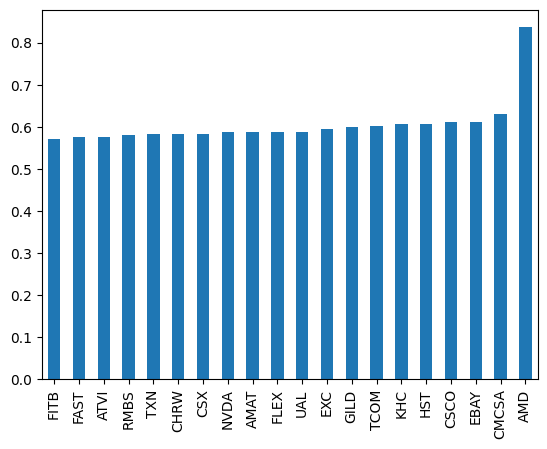

In [ ]:
best_acc_companies = [index_to_company[k] for k in acc_per_company.argsort()[-20:]]
best_acc_companies
pd.Series(data=acc_per_company[acc_per_company.argsort()[-20:]], index=best_acc_companies).plot.bar()

In [ ]:
news_df["symbol"].value_counts()

AAPL     18777
MSFT      7574
AMZN      6136
GOOGL     4852
TSLA      4097
         ...  
CIZN         1
BELFA        1
DMLP         1
ATLO         1
CZNC         1
Name: symbol, Length: 325, dtype: int64

In [ ]:
news_df[news_df["symbol"].isin(best_acc_companies)]["symbol"].value_counts()

UAL      447
CMCSA    437
NVDA     407
GILD     390
CSCO     355
AMD      205
AMAT     200
EBAY     176
CSX      165
KHC      161
TXN      139
ATVI     120
FITB      93
FAST      77
EXC       63
HST       42
CHRW      34
TCOM      26
RMBS      11
FLEX      10
Name: symbol, dtype: int64